In [1]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray' 
import numpy as np
import os
from glob import glob
import SimpleITK as sitk
import cv2
import argparse
from tqdm import tqdm

def myshow(img, title=None, margin=0.05, dpi=80 ):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    slicer = False
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            slicer = True
    elif nda.ndim == 4:
        c = nda.shape[-1]
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
        # take a z-slice
        slicer = True
    if (slicer):
        ysize = nda.shape[1]
        xsize = nda.shape[2]
    else:
        ysize = nda.shape[0]
        xsize = nda.shape[1]
    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    def callback(z=None):
        extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
        fig = plt.figure(figsize=figsize, dpi=dpi)
        # Make the axis the right size...
        ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
        plt.set_cmap("gray")
        if z is None:
            ax.imshow(nda,extent=extent,interpolation=None)
        else:
            ax.imshow(nda[z,...],extent=extent,interpolation=None)
        if title:
            plt.title(title)
        plt.show()
    if slicer:
        interact(callback, z=(0,nda.shape[0]-1))
    else:
        callback()
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    img_null = sitk.Image([0,0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())
    img_slices = []
    d = 0
    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1
    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1
    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TODO check in code to get Tile Filter working with VectorImages
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
    myshow(img, title, margin, dpi)
    

def crop_img(img, mask, diameter_mm=110):
    z_list, sum_list = [], []
    for idx, m in enumerate(mask):
        if np.all((m == 0))== False:
            z_list.append(idx)
            sum_list.append(m.sum())

    num_slices = int(100 // voxel_space[2])
    min_z = z_list[0]
    max_z = min_z + num_slices
    img_crop = img[min_z:max_z]
    mask_crop = mask[min_z:max_z]
    ref_index = z_list[np.argmax(sum_list)]
    nonzero_idx = np.nonzero(mask[ref_index])

    center_x = int(np.median(nonzero_idx[0]))
    center_y = int(np.median(nonzero_idx[1]))
    diameter_pixel = int(diameter_mm//voxel_space[0])
    radius = diameter_pixel//2
    for idx, (img, mask) in enumerate(zip(img_crop, mask_crop)):
        zeros = np.zeros(img.shape)
        cv2.circle(zeros,(center_y, center_x), radius, 1, -1)
        img_crop[idx] = img * zeros
        mask_crop[idx] = mask * zeros
    post_img = img_crop[:, center_x-radius:center_x+radius, center_y-radius:center_y+radius]
    post_mask = mask_crop[:, center_x-radius:center_x+radius, center_y-radius:center_y+radius]
    return post_img, post_mask

def window(img, WL=250, WW=2000):
    upper, lower = WL+WW//2, WL-WW//2
    X = np.clip(img.copy(), lower, upper)
    X = X - np.min(X)
    X = X / (np.max(X)- np.min(X))
#     X = (X*255.0).astype('uint8')
    return X

In [3]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--input_path', type=str, default = "../data/HNCetuximabclean/") 
    parser.add_argument('--output_path', type=str, default = "../data/process/HNCetuximabclean") 
    
#     parser.add_argument('--n_core', type=int, default = 4) # max 4
    args, _ = parser.parse_known_args()


In [4]:
output_path = args.output_path
os.makedirs(output_path, exist_ok=True)
npy_path = os.path.join(output_path, "npy")
os.makedirs(npy_path,exist_ok=True)
data_csv = os.path.join(output_path,'data.csv')
fail_csv = os.path.join(output_path,'fail.csv')

with open(data_csv, 'w') as f:
    f.write('ID,row,column,slice,voxel_x,voxel_y,voxel_z,p_row,p_column,p_slice\n')

with open(fail_csv, 'w') as f:
    f.write('ID\n')
    
data_list = sorted(glob(os.path.join(args.input_path, "*")))
data_list = [data.replace("\\","/") for data in data_list]

for index in tqdm(range(len(data_list))):
    ID = data_list[index].split("/")[-1]
    mandible_path = os.path.join(data_list[index], "structures", "Mandible.nrrd")
    # mandible_path = os.path.join(data_list[index], "structures", "Mandible_crp_v2.npy")

    if os.path.exists(mandible_path)==False:
#         print(f"{ID} Mandible data does not exist!")
        with open(fail_csv, 'a') as f:
            f.write(f'{ID}\n')
        continue

    img_path = os.path.join(data_list[index], "img.nrrd")
    # img_path = os.path.join(data_list[index], "img_crp_v2.npy")

    sitkimg = sitk.ReadImage(img_path)
    sitkmask = sitk.ReadImage(mandible_path)

    voxel_space = sitkimg.GetSpacing()


    img = sitk.GetArrayFromImage(sitkimg)
    # img = np.load(img_path)
    mask = sitk.GetArrayFromImage(sitkmask)
    # mask = np.load(mandible_path)

    
    img = window(img, WL=200, WW=1200) # 1200
    post_img, post_mask = crop_img(img, mask,diameter_mm=160)
    post_img = (post_img*255).astype(np.uint8)
    post_mask = post_mask.astype(np.uint8)
    
    with open(data_csv, 'a') as f:
        f.write(f'{ID},{img.shape[2]},{img.shape[1]},{img.shape[0]},{voxel_space[2]},{voxel_space[1]},{voxel_space[0]},{post_img.shape[2]},{post_img.shape[1]},{post_img.shape[0]}\n')


    save_img = os.path.join(npy_path , f"{ID}_image.npy")
    save_mask = os.path.join(npy_path , f"{ID}_mask.npy")
    np.save(save_img, post_img)
    np.save(save_mask, post_mask)



100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:15<00:00,  2.95it/s]


In [8]:
from ipywidgets import interact, interactive

myshow3d(sitk.GetImageFromArray(post_img))

interactive(children=(IntSlider(value=32, description='z', max=65), Output()), _dom_classes=('widget-interact'…

In [32]:
img = np.load('../data/process/HNCetuximabclean/npy/0522c0449_image.npy')
mask = np.load('../data/process/HNCetuximabclean/npy/0522c0449_mask.npy')

In [33]:
myshow3d(sitk.GetImageFromArray(img))

interactive(children=(IntSlider(value=84, description='z', max=168), Output()), _dom_classes=('widget-interact…

In [20]:
myshow3d(sitk.GetImageFromArray(mask))

interactive(children=(IntSlider(value=19, description='z', max=39), Output()), _dom_classes=('widget-interact'…

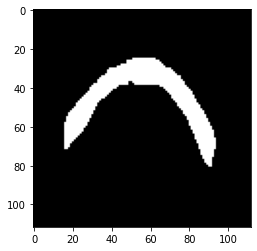

In [79]:
post_mask = mask[center_x-radius:center_x+radius, center_y-radius:center_y+radius]
plt.imshow(post_mask)

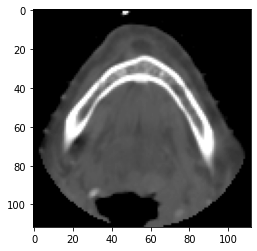

In [80]:
post_img = center_img[center_x-radius:center_x+radius, center_y-radius:center_y+radius]
plt.imshow(post_img)